# SIMPLE CIRCLE IN 2D IN MIDDEL

comparing wite the firedrake https://github.com/firedrakeproject/firedrake/blob/dolci/fwi_demo/demos/full_waveform_inversion/full_waveform_inversion.py.rst exampel

In [1]:
import sys
sys.path.append("/Users/yw11823/ACSE/irp/spyro")

import os
os.environ["OMP_NUM_THREADS"] = "1"

from firedrake import *
import numpy as np
import finat
from ROL.firedrake_vector import FiredrakeVector as FeVector
import ROL
from mpi4py import MPI
import psutil

import spyro

We consider a two dimensional square domain with side length 1.0 km. The mesh is created over the ？？？The basic input for the FWI problem are defined as follows:

In [2]:
sou_pos = [(0, 0.5)]
rec_pos = spyro.create_transect((1.0, 0.0), (1.0, 1.0), 980)

# t0 =  0.0, 
# tf = 2.0, 
# dt = 5e-4,
# freq = 8.0, 

model = {}
model["opts"] = {
    "method": "KMV", 
    "quadrature": "KMV", 
    "degree": 1, 
    "dimension": 2, 
}
model["parallelism"] = {
    "type": "spatial", 
}
model["mesh"] = {
    "Lz": 1.0, 
    "Lx": 1.0, 
    "Ly": 0.0, 
    "meshfile": "not_used.msh", 
    "initmodel": "not_used.hdf5", 
    "truemodel": "not_used.hdf5", 
}
model["BCs"] = {
    "status": True, 
    "outer_bc": "non-reflective", 
    "damping_type": "polynomial", 
    "exponent": 2, 
    "cmax": 4.5, 
    "R": 1e-6, 
    "lz": 0.25, 
    "lx": 0.25,  
    "ly": 0.0, 
}
model["acquisition"] = {
    "source_type": "Ricker", 
    "source_pos": sou_pos, 
    "frequency": 8.0, 
    "delay": 0.1, 
    "receiver_locations": rec_pos, 
}
model["timeaxis"] = {
    "t0": 0.0, 
    "tf": 2.0, 
    "dt": 5e-4, 
    "amplitude": 1, 
    "nspool": 100, 
    "fspool": 100, 
}


We are using a 2D domain, 980 receivers, and 1 sources. Sources and receivers locations is illustrated in the following figure:

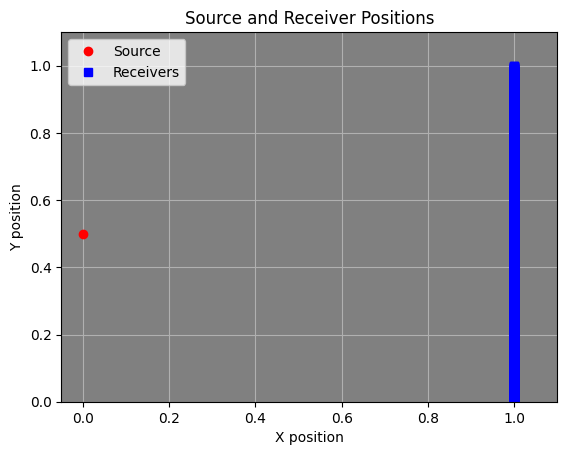

In [3]:
import matplotlib.pyplot as plt 

# Plotting
fig, ax = plt.subplots()
ax.plot(*zip(*sou_pos), 'ro', label='Source')  # red dot for source
ax.plot(*zip(*rec_pos), 'bs', label='Receivers')  # blue squares for receivers

# Setting the axis limits to match the example
ax.set_xlim(-0.05, 1.1)
ax.set_ylim(0, 1.1)

# Adding a grid and legend
ax.grid(True)
ax.legend()
ax.set_facecolor('gray')

# Adding labels
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_title('Source and Receiver Positions')

plt.show()


In [4]:
# mesh = UnitSquareMesh(100, 100, 1.0, 1.0)
mesh = RectangleMesh(100, 100, 1.0, 1.0)
# mesh.coordinates.dat.data[:, 0] -= 0.25 将x坐标向左平移0.25个单位
# mesh.coordinates.dat.data[:, 1] -= 1.25 将y坐标向下平移1.25个单位

comm = spyro.utils.mpi_init(model)
element = spyro.domains.space.FE_method(mesh, model["opts"]["method"], model["opts"]["degree"])
V = FunctionSpace(mesh, element)

We consider a two dimensional square domain with side length 1.0 km. And a two layer simple velocity model with the velocity to 3.0 inside the circle (where the condition is true) and to 2.5 outside the circle (where the condition is false). Velocity graph is illustrated in the following figure:

In [5]:
# Create a simple two-layer seismic velocity model `vp`.
x, y = SpatialCoordinate(mesh)
radius = 0.3
center_x, center_y = 0.5, 0.5
condition = (x - center_x)**2 + (y - center_y)**2 < radius**2
velocity = conditional(condition, 3.0, 2.5)
vp = Function(V, name="velocity").interpolate(velocity)
File("true_velocity_model_circle.pvd").write(vp)


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


加图

Acquisition geometry

Wave graph is illustrated in the following figure:

In [6]:
sources = spyro.Sources(model, mesh, V, comm)
receivers = spyro.Receivers(model, mesh, V, comm)

In [7]:
dt=model["timeaxis"]["dt"]
tf=model["timeaxis"]["tf"]
freq=model["acquisition"]["frequency"]

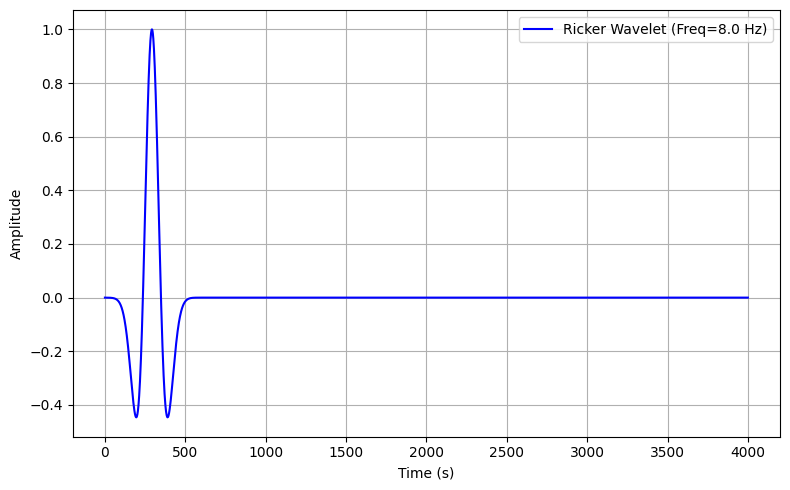

In [8]:
wavelet = spyro.full_ricker_wavelet( dt= dt, tf = tf, freq= freq)

# 绘图
plt.figure(figsize=(8, 5))
plt.plot( wavelet, color='blue', linewidth=1.5, label=f'Ricker Wavelet (Freq={freq} Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Perform a seismic forward simulation, then plot and save the pressure field data at the receivers.


In [9]:
p_field, p_at_recv = spyro.solvers.forward(model, mesh, comm, vp, sources, wavelet, receivers)
spyro.plots.plot_shots(model, comm, p_at_recv)
spyro.io.save_shots(model, comm, p_at_recv)

/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
/Users/yw11823/ACSE/irp/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "
/Users/yw11823/ACSE/irp/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "
/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .spli

Simulation time is:     0.0495 seconds
Simulation time is:     0.0995 seconds
Simulation time is:     0.1495 seconds
Simulation time is:     0.1995 seconds
Simulation time is:     0.2495 seconds
Simulation time is:     0.2995 seconds
Simulation time is:     0.3495 seconds
Simulation time is:     0.3995 seconds
Simulation time is:     0.4495 seconds
Simulation time is:     0.4995 seconds
Simulation time is:     0.5495 seconds
Simulation time is:     0.5995 seconds
Simulation time is:     0.6495 seconds
Simulation time is:     0.6995 seconds
Simulation time is:     0.7495 seconds
Simulation time is:     0.7995 seconds
Simulation time is:     0.8495 seconds
Simulation time is:     0.8995 seconds
Simulation time is:     0.9495 seconds
Simulation time is:     0.9995 seconds
Simulation time is:       1.05 seconds
Simulation time is:      1.099 seconds
Simulation time is:      1.149 seconds
Simulation time is:        1.2 seconds
Simulation time is:       1.25 seconds
Simulation time is:      

In [10]:
p_at_recv

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [7.16741416e-08, 7.12808948e-08, 7.08876480e-08, ...,
        7.12844523e-08, 7.16821821e-08, 7.20799119e-08],
       [7.12306417e-08, 7.08286287e-08, 7.04266156e-08, ...,
        7.08108404e-08, 7.12182505e-08, 7.16256606e-08],
       [7.07795522e-08, 7.03704044e-08, 6.99612565e-08, ...,
        7.03279447e-08, 7.07434682e-08, 7.11589916e-08]])

In [11]:
p_field

[Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x1438ccfd0>, FiniteElement('Kong-Mulder-Veldhuizen', triangle, 1, variant='KMV'), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 1)), 95),
 Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x1438ccfd0>, FiniteElement('Kong-Mulder-Veldhuizen', triangle, 1, variant='KMV'), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 1)), 97),
 Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x1438ccfd0>, FiniteElement('Kong-Mulder-Veldhuizen', triangle, 1, variant='KMV'), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 1)), 99),
 Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x1438ccfd0>, FiniteElement('Kong-Mulder-Veldhuizen', triangle, 1, variant='KMV'), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 1)), 1

# now, let us do the fwi

1. initialization:
Import necessary libraries and modules.
Define the mesh, function space, and initial velocity model.
2. Set Initial Guess Parameter
3. Solve the Wave Equation useing the initial geuess velocity model
4. Compute the Functional J: Calculate the objective functional J, such as the difference between the observed and simulated data.
5. Compute the Gradient: Use the adjoint method to compute the gradient of the functional J with respect to the control parameter c_guess.
6. Optimization Update: Update the parameter c_guess using a gradient-based optimization method, such as L-BFGS-B.
7. Repeat Optimization Steps: 

In [12]:
outdir = "out/"
if not os.path.exists(outdir):
    os.mkdir(outdir)

creat the inital velocity graph (smoothed)

In [13]:
# Create a simple two-layer seismic velocity model `vp`.
x, y = SpatialCoordinate(mesh)
radius = 0.3
center_x, center_y = 0.5, 0.5
condition = (x - center_x)**2 + (y - center_y)**2 < radius**2
velocity = conditional(condition, 2.5, 2.5)
vp = Function(V, name="velocity").interpolate(velocity)
File("initial_velocity_model_circle.pvd").write(vp)

## 加图！！

/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


In [14]:
# Set up file output for control and gradient fields if on the master process, and define a lumped quadrature rule for integration.
if comm.ensemble_comm.rank == 0:
    control_file = File(outdir + "control.pvd", comm=comm.comm)
    grad_file = File(outdir + "grad.pvd", comm=comm.comm)
quad_rule = finat.quadrature.make_quadrature(V.finat_element.cell, V.ufl_element().degree(), "KMV")
dxlump = dx(scheme=quad_rule)

/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


Define an L2 inner product class for vector operations and a function to regularize the gradient of the velocity model using finite element methods.

In [15]:
class L2Inner(object):
    def __init__(self):
        self.A = assemble(TrialFunction(V) * TestFunction(V) * dxlump, mat_type="matfree")
        self.Ap = as_backend_type(self.A).mat()

    def eval(self, _u, _v):
        upet = as_backend_type(_u).vec()
        vpet = as_backend_type(_v).vec()
        A_u = self.Ap.createVecLeft()
        self.Ap.mult(upet, A_u)
        return vpet.dot(A_u)

def regularize_gradient(vp, dJ):
    m_u = TrialFunction(V)
    m_v = TestFunction(V)
    mgrad = m_u * m_v * dx(scheme=quad_rule)
    ffG = dot(grad(vp), grad(m_v)) * dx(scheme=quad_rule)
    G = mgrad - ffG
    lhsG, rhsG = lhs(G), rhs(G)
    gradreg = Function(V)
    grad_prob = LinearVariationalProblem(lhsG, rhsG, gradreg)
    grad_solver = LinearVariationalSolver(
        grad_prob,
        solver_parameters={
            "ksp_type": "preonly",
            "pc_type": "jacobi",
            "mat_type": "matfree",
        },
    )
    grad_solver.solve()
    dJ += gradreg
    return dJ

 Opitimisation
Define an objective class for optimization that computes the objective function value and its gradient for seismic inversion, and updates the velocity model based on optimization iterations.

In [25]:
class Objective(ROL.Objective):
    def __init__(self, inner_product):
        ROL.Objective.__init__(self)
        self.inner_product = inner_product
        self.p_guess = None
        self.misfit = 0.0
        self.p_exact_recv = spyro.io.load_shots(model, comm)

    def value(self, x, tol):
        J_total = np.zeros((1))
        self.p_guess, p_guess_recv = spyro.solvers.forward(
            model,
            mesh,
            comm,
            vp,
            sources,
            wavelet,
            receivers,
        )
        self.misfit = spyro.utils.evaluate_misfit(model, p_guess_recv, self.p_exact_recv)
        J_total[0] += spyro.utils.compute_functional(model, self.misfit, velocity=vp)
        J_total = COMM_WORLD.allreduce(J_total, op=MPI.SUM)
        J_total[0] /= comm.ensemble_comm.size
        if comm.comm.size > 1:
            J_total[0] /= comm.comm.size
        return J_total[0]
    
    def gradient(self, g, x, tol):
        dJ = Function(V, name="gradient")

        print("Before calling spyro.solvers.gradient:")
        print("self.p_guess:", self.p_guess)
        print("model:", model)
        print("mesh:", mesh)
        print("comm:", comm)
        print("vp:", vp)
        print("receivers:", receivers)
        print("self.misfit:", self.misfit)
        
        dJ_local = spyro.solvers.gradient(
            model,
            mesh,
            comm,
            vp,
            receivers,
            self.p_guess,
            self.misfit,
        )

        print("After calling spyro.solvers.gradient:")
        if comm.ensemble_comm.size > 1:
            comm.allreduce(dJ_local, dJ)
        else:
            dJ = dJ_local
        dJ /= comm.ensemble_comm.size
        if comm.comm.size > 1:
            dJ /= comm.comm.size
        if "regularization" in model["opts"] and model["opts"]["regularization"]:
            dJ = regularize_gradient(vp, dJ)
        if comm.ensemble_comm.rank == 0:
            grad_file.write(dJ)
        g.scale(0)
        g.vec += dJ

    def update(self, x, flag, iteration):
        vp.assign(Function(V, x.vec, name="velocity"))
        if iteration >= 0:
            if comm.ensemble_comm.rank == 0:
                control_file.write(vp)

Configure optimization parameters for the Limited-Memory BFGS method and Augmented Lagrangian approach using a parameter list.

In [23]:
# 调用 gradient 函数之前添加打印语句
print("Before calling spyro.solvers.gradient:")
print("self.p_guess:", guess)
print("model:", model)
print("mesh:", mesh)
print("comm:", comm)
print("vp:", vp)
print("receivers:", receivers)
print("self.misfit:", res)

dJ_local = spyro.solvers.gradient(
    model,
    mesh,
    comm,
    vp,
    receivers,
    guess,
    residual,
)

print("After calling spyro.solvers.gradient:")



Before calling spyro.solvers.gradient:


NameError: name 'self' is not defined

In [17]:
paramsDict = {
    "General": {"Secant": {"Type": "Limited-Memory BFGS", "Maximum Storage": 10}},
    "Step": {
        "Type": "Augmented Lagrangian",
        "Augmented Lagrangian": {
            "Subproblem Step Type": "Line Search",
            "Subproblem Iteration Limit": 5,
        },
        "Line Search": {"Descent Method": {"Type": "Quasi-Newton Step"}},
    },
    "Status Test": {
        "Gradient Tolerance": 1e-15,
        "Iteration Limit": 100,
        "Step Tolerance": 1e-15,
    },
}

params = ROL.ParameterList(paramsDict, "Parameters")

In [ ]:




# # algo = ROL.Algorithm("Line Search", params)

# algo = ROL.LinMoreAlgorithm(params)

# algo.run(opt, obj)

# if comm.ensemble_comm.rank == 0:
#     File("res.pvd", comm=comm.comm).write(vp)

In [19]:
params = ROL.ParameterList(paramsDict, "Parameters")

inner_product = L2Inner()

obj = Objective(inner_product)

u = Function(V, name="velocity").assign(vp)




opt = FeVector(u.vector(), inner_product)
# Add control bounds to the problem (uses more RAM)
xlo = Function(V)
xlo.interpolate(Constant(1.0))
x_lo = FeVector(xlo.vector(), inner_product)

xup = Function(V)
xup.interpolate(Constant(5.0))
x_up = FeVector(xup.vector(), inner_product)

bnd = ROL.Bounds(x_lo, x_up, 1.0)

# Set up the line search
# algo = ROL.Algorithm("Line Search", params)
algo = ROL.LinMoreAlgorithm(params)

algo.run(opt, obj, bnd)

if comm.ensemble_comm.rank == 0:
    File("res.pvd", comm=comm.comm).write(obj.vp)

/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
/Users/yw11823/ACSE/irp/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "


Simulation time is:     0.0495 seconds
Simulation time is:     0.0995 seconds
Simulation time is:     0.1495 seconds
Simulation time is:     0.1995 seconds
Simulation time is:     0.2495 seconds
Simulation time is:     0.2995 seconds
Simulation time is:     0.3495 seconds
Simulation time is:     0.3995 seconds
Simulation time is:     0.4495 seconds
Simulation time is:     0.4995 seconds
Simulation time is:     0.5495 seconds
Simulation time is:     0.5995 seconds
Simulation time is:     0.6495 seconds
Simulation time is:     0.6995 seconds
Simulation time is:     0.7495 seconds
Simulation time is:     0.7995 seconds
Simulation time is:     0.8495 seconds
Simulation time is:     0.8995 seconds
Simulation time is:     0.9495 seconds
Simulation time is:     0.9995 seconds
Simulation time is:       1.05 seconds
Simulation time is:      1.099 seconds
Simulation time is:      1.149 seconds
Simulation time is:        1.2 seconds
Simulation time is:       1.25 seconds
Simulation time is:      

/Users/yw11823/ACSE/irp/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "
/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
/Users/yw11823/ACSE/irp/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "
/Users/yw11823/ACSE/irp/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str

Simulation time is:       1.95 seconds


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Simulation time is:        1.9 seconds
Simulation time is:       1.85 seconds
Simulation time is:        1.8 seconds
Simulation time is:       1.75 seconds
Simulation time is:        1.7 seconds
Simulation time is:       1.65 seconds
Simulation time is:        1.6 seconds
Simulation time is:       1.55 seconds
Simulation time is:        1.5 seconds
Simulation time is:       1.45 seconds
Simulation time is:        1.4 seconds
Simulation time is:       1.35 seconds
Simulation time is:        1.3 seconds
Simulation time is:       1.25 seconds
Simulation time is:        1.2 seconds
Simulation time is:       1.15 seconds
Simulation time is:        1.1 seconds
Simulation time is:       1.05 seconds
Simulation time is:        1.0 seconds
Simulation time is:       0.95 seconds
Simulation time is:        0.9 seconds
Simulation time is:       0.85 seconds
Simulation time is:        0.8 seconds
Simulation time is:       0.75 seconds
Simulation time is:        0.7 seconds
Simulation time is:      

/Users/yw11823/ACSE/irp/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "
/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
/Users/yw11823/ACSE/irp/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "


IndexError: pop from empty list

In [19]:
inner_product = L2Inner()

obj = Objective(inner_product)

u = Function(V, name="velocity").assign(vp)
File("u_velocity_model.pvd").write(u)

In [20]:
# opt = FeVector(u.vector(), inner_product)

# # 创建上界和下界的 Function 对象
# lower_bound = Function(V, name="Lower Bound").interpolate(Constant(1500))
# upper_bound = Function(V, name="Upper Bound").interpolate(Constant(4500))

# print("Lower bound size:", lower_bound.vector().size())
# print("Upper bound size:", upper_bound.vector().size())
# print("Optimization variable size:", opt.vec.size())


In [21]:
# # Test run without bounds to see if error persists
# try:
#     algo.run(opt, obj)  # Run without bounds
#     print("Run successful without bounds")
# except Exception as e:
#     print("Error running without bounds:", e)

# # If no errors, reintroduce bounds and check initialization:
# if 'bounds' in locals():
#     try:
#         algo.run(opt, obj, bounds)  # Run with bounds
#         print("Run successful with bounds")
#     except Exception as e:
#         print("Error running with bounds:", e)


In [1]:
opt = FeVector(u.vector(), inner_product)

# algo = ROL.Algorithm("Line Search", params)

algo = ROL.LinMoreAlgorithm(params)

algo.run(opt, obj)

# # 创建上界和下界的 Function 对象
# lower_bound = Function(V, name="Lower Bound").interpolate(Constant(1500))
# upper_bound = Function(V, name="Upper Bound").interpolate(Constant(4500))

# # Assuming inner_product is defined somewhere in your script as an instance of L2Inner or similar
# # 创建 ROL.Bounds 对象，确保传入 inner_product
# bounds = ROL.Bounds(FeVector(lower_bound.vector(), inner_product), FeVector(upper_bound.vector(), inner_product))

# # 在优化算法中使用界限
# algo.run(opt, obj, bounds)

# 在优化算法中使用界限、
algo.run(opt, obj, bounds)


if comm.ensemble_comm.rank == 0:
    File("res.pvd", comm=comm.comm).write(vp)

NameError: name 'FeVector' is not defined